In [1]:
import pandas as pd
import numpy as np
from data_analysis import get_heart_bounds, correlation_coef, graph_3d
from graph import narrow,corrplot3axes,trend,nearest,plot_exploration, graph_dist_over_axis, graph_cc_distribution
from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
from prettytable import PrettyTable
%matplotlib qt 


def get_index(label):
    """
    Gets the idx of a label in the labels array
    :param label: label to check for
    :return: idx
    """
    idx = 0
    for coord in labels:
        if np.array_equal(label, coord):
            break
        idx += 1
    return idx


def black_box(x, y, z):
    """
    Represents a black box function to maximize for CC of two ECGs given an XYZ coordinate
    :param x:
    :param y: coordinates of the prediction
    :param z:
    :return: CC of that point and the target
    """
    sample_ecg = ecgs[get_index(np.array([x, y, z]))]
    return correlation_coef(target_ecg, sample_ecg)


def plot_exploration(visited, color_gradient):
    """
    Handles plotting the predictions of the network over time
    :param visited:
    :return:
    """
    path = np.array(visited)
    color_gradient = np.array(color_gradient)


    # Plot final for viewing
    rest = np.delete(labels, np.where(np.isin(labels, path)), axis=0)
    color_gradient = np.delete(color_gradient, np.where(np.isin(labels, path)), axis=0)
#     fig = plt.figure(0)
    fig = plt.figure(figsize=(8,8)); ax = Axes3D(fig)
    ax = fig.gca(projection='3d')

    ax.scatter(xs=rest[:, 0], ys=rest[:, 1], zs=rest[:, 2], zdir='z', alpha=0.75, c=color_gradient, cmap = plt.cm.Reds)
    ax.scatter(xs=path[:, 0], ys=path[:, 1], zs=path[:, 2], zdir='z', color='blue')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color = 'blue')

    m = path
    for i in range(len(m)):
        ax.text(m[i, 0], m[i, 1], m[i, 2], '%s' % (str(i)), size=10, zorder=1, color='k')
    ax.scatter(xs=target[0], ys=target[1], zs=target[2], color='black', s = 100)
    plt.show()



In [2]:
ecgs = pd.read_csv("new_simu-data/Heart1/Heart1_SimuData_4000.csv", header=None).to_numpy()
labels = pd.read_csv("new_simu-data/Heart1/Coord1_4000.csv", header=None).to_numpy() / 1000
print(ecgs.shape)
# Get bounds of the heart mesh
bounds = get_heart_bounds(labels)
# Pick out a sample to use as a target
tidx = np.random.randint(0, labels.shape[0])
#tidx = 1
target, target_ecg = labels[tidx], ecgs[tidx]
print("Target: ", target)

(4000, 7212)
Target:  [ 12.3859 -85.6213  18.9371]


In [3]:
def optimize_point(labels):
    # Build the optimizer with the heart bounds
    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=bounds,
        random_state=None, real_set=labels
    )

    # Maximize over x number of points
    optimizer.maximize(init_points=10, n_iter=35,  acq="ucb", kappa = 2)
    return optimizer


In [4]:
optimizer = BayesianOptimization(
    f=black_box,
    pbounds=bounds,
    random_state=None, real_set=labels
)

In [5]:
gp,x = optimizer.gpfit(init_points=5,n_iter=10,acq='ucb',kappa=2.576)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.8251   |  24.8     | -65.81    |  22.6     |
|  2        | -0.2576   | -22.29    | -24.51    | -21.91    |
|  3        |  0.4789   |  8.924    | -29.52    | -0.1551   |
|  4        |  0.6966   |  9.381    | -46.75    |  22.77    |
|  5        |  0.7313   |  20.63    | -39.41    |  28.37    |
|  6        |  0.7313   |  20.63    | -39.41    |  28.37    |
|  7        |  0.7313   |  20.63    | -39.41    |  28.37    |
|  8        |  0.7313   |  20.63    | -39.41    |  28.37    |
|  9        |  0.7313   |  20.63    | -39.41    |  28.37    |
|  10       |  0.8428   |  24.72    | -65.12    |  20.73    |
|  11       | -0.2583   |  32.63    | -97.53    | -33.85    |
|  12       |  0.3358   | -39.11    | -90.92    |  29.75    |
|  13       |  0.7765   |  28.85    | -77.64    |  21.5     |
|  14       |  0.6557   |  22.9     | -30.42    |  19.87    |
|  15   

In [6]:
x_train = np.asarray(optimizer.visited)
y_train=optimizer._space.target.reshape(-1,1)
gp.fit(x_train,y_train)
y_train.shape


ValueError: Found input variables with inconsistent numbers of samples: [15, 10]

In [ ]:
X = np.arange(-94, 34, 4)
len(X)

In [ ]:
import seaborn as sns
def graph_cc_distribution(target,ecgs,labels):
    """
    Function that handles color coating the 3d mesh to see the distribution of CC over distance from a given target
    coordinate. Useful to see the general function in 3D
    """
    # Lists to hold the points with the color coating
    true, blue, green, yellow, red = None, [], [], [], []
    color_gradient = []
    # Loop through all points to get CC with that point
    for ecg, coord in zip(ecgs, labels):
        if np.array_equal(target, ecg):
            true = coord
            color_gradient.append(1)
            continue
        cc = correlation_coef(target, ecg)
        color_gradient.append(cc)
    sns.set(style = "darkgrid")
    fig = plt.figure(33)
    ax = fig.gca(projection='3d')
    img = ax.scatter(xs=labels[:, 0], ys=labels[:, 1], zs=labels[:, 2],s = 5, c=color_gradient, cmap = plt.cm.rainbow)
    ax.scatter(true[0], true[1], true[2], color='black', marker = "X", s = 200)
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    fig.colorbar(img)
    fig.suptitle('Actual CC plot', fontsize=16)
    plt.show()

In [ ]:
graph_cc_distribution(target_ecg,ecgs,labels)


In [ ]:
def trend(target,visited,actual):
    visited = np.asarray(visited)
    actual = np.asarray(actual)
    visited = visited[len(visited)-len(actual):len(visited)]
    dis_tar_act = []
    dis_tar_vis = []
    dis_dif = []
    for i in range(len(actual)):
        d1 = np.linalg.norm(target-visited[i,:])
        dis_tar_vis = np.append(dis_tar_vis,d1)
        d2 = np.linalg.norm(target-actual[i,:])
        dis_tar_act = np.append(dis_tar_act,d2)
        d3 = np.linalg.norm(actual[i,:]-visited[i,:])
        dis_dif = np.append(dis_dif,d3)
    fig = plt.figure(10)
    plt.plot(dis_tar_vis,label = 'between target and visited')
    plt.plot(dis_tar_act,label = 'between target and predicted')
    plt.plot(dis_dif, label = 'between predicted and visited')
    plt.xlabel("iteration")
    plt.ylabel("distance")
    plt.legend(loc='upper right')
    plt.show()

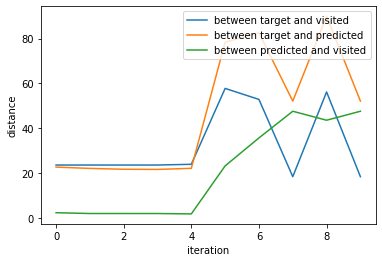

In [7]:
trend(target,optimizer.visited,optimizer.predicted)

In [25]:
tt=optimizer.predicted[6]

In [26]:
def approx(suggestion,real_set):
    dist = []
    for i in range(len(real_set)):
        d = euclidean_distance(suggestion, real_set[i])
        dist = np.append(dist,d)
    m = np.amin(dist)
    for j in range(len(dist)):
        if dist[j]==m:
            t = real_set[j]
            break
    return t,m

In [22]:
t,m = approx(tt,labels)

In [24]:
labels.shape

(4000, 3)

In [10]:
def euclidean_distance(one, two):
    """ Computes the euclidean distance between two coordinates """
    return np.sqrt(np.sum((one - two)**2))

In [14]:
target

array([ 12.3859, -85.6213,  18.9371])

In [ ]:
np.quantile(ecgs[1],0.5)

In [ ]:
plt.hist(ecgs[1])
plt.show()

In [ ]:
def all_mean(ecgs):
    mean_array = []
    var_array = []
    for i in range(len(ecgs)):
        m = np.mean(ecgs[i])
        v = np.var(ecgs[i])
        mean_array = np.append(mean_array,m)
        var_array = np.append(var_array,v)
    return mean_array, var_array
        
        

In [ ]:
mean, var = all_mean(ecgs)

In [ ]:
plt.hist(var)
plt.show()

In [ ]:
def nearest(tidx,labels,ecgs,dis_limit):
    target_loc = labels[tidx]
    target_ecg = ecgs[tidx]
    cc = np.array([[1]])
    dis = np.array([[0]])
    mean_target = np.array([[0]])+np.quantile(target_ecg,0.25)
    var_target = np.array([[0]])+np.quantile(target_ecg,0.75)
    first_row=np.concatenate((target_loc.reshape(1,3), dis,cc,mean_target,var_target),axis =1)
    nn_loc = np.empty((0, 3))
    nn_cc = np.empty ((0,1))
    nn_dis = np.empty((0,1))
    nn_mean = np.empty((0,1))
    nn_var = np.empty((0,1))
    for i in range(len(labels)):
        d = np.sqrt(np.sum((target_loc - labels[i])**2))
        if d < dis_limit:
            nn_loc = np.append(nn_loc,labels[i].reshape(1,3),axis=0)
            nn_cc = np.append(nn_cc,np.corrcoef(target_ecg, ecgs[i])[0, 1])
            nn_dis = np.append(nn_dis,d)
            nn_mean = np.append(nn_mean,np.quantile(ecgs[i],0.25))
            nn_var = np.append(nn_var,np.quantile(ecgs[i],0.75))
    nn_dis = nn_dis.reshape(-1,1)
    nn_cc = nn_cc.reshape(-1,1)
    nn_mean = nn_mean.reshape(-1,1)
    nn_var = nn_var.reshape(-1,1)
    near_points = np.concatenate((nn_loc, nn_dis, nn_cc,nn_mean,nn_var),axis =1)
    table = np.concatenate((first_row,near_points), axis = 0)
    table = np.around(table,2)
    return table
table=nearest(tidx,labels,ecgs,15)
# plt.scatter(table[:,3],table[:,4])
# plt.xlabel("distance")
# plt.ylabel("correlation")
# plt.show
x= PrettyTable()
x.field_names = ['x', 'y','z','Distance','Corr','Q1','Q3']
for row in table:
    x.add_row(row)
print(x)

In [ ]:
nearest(tidx,labels,ecgs,20)

In [ ]:
def gp_plot(gp):
    X = np.arange(-35, 95, 3)
    Y = np.arange(-119, 3, 3)
    Z = np.arange(-91, 8, 3)
    gpm = []
    loc = np.empty((0, 3))
    for i in range(len(X)):
        for j in range(len(Y)):
            for k in range(len(Z)):
                d = gp.predict(np.array([X[i],Y[j],Z[k]]).reshape(1,-1),return_std=False)
                loc = np.append(loc,np.array([X[i],Y[j],Z[k]]).reshape(1,-1),axis=0)
                gpm = np.append(gpm,d)
    fig = plt.figure(60)
    ax = fig.gca(projection='3d')
    img = ax.scatter(xs=loc[:, 0], ys=loc[:, 1], zs=loc[:, 2], c=gpm, cmap = plt.cm.rainbow)
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    fig.colorbar(img)
    fig.suptitle('CC distribution on GP', fontsize=16)
    plt.show()

In [ ]:
gp_plot(gp)

In [ ]:
np.amin(labels[:,0])

In [ ]:
def plot_exploration(visited, color_gradient):
    """
    Handles plotting the predictions of the network over time
    :param visited:
    :return:
    """
    path = np.array(visited)
    color_gradient = np.array(color_gradient)

    # Plot final for viewing
    rest = np.delete(labels, np.where(np.isin(labels, path)), axis=0)
    color_gradient = np.delete(color_gradient, np.where(np.isin(labels, path)), axis=0)
    fig = plt.figure(0)
    ax = fig.gca(projection='3d')

    ax.scatter(xs=rest[:, 0], ys=rest[:, 1], zs=rest[:, 2], zdir='z', alpha=0.75, c=color_gradient, cmap = plt.cm.Reds)
    ax.scatter(xs=path[:, 0], ys=path[:, 1], zs=path[:, 2], zdir='z', color='blue')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color = 'blue')

    m = path
    for i in range(len(m)):
        ax.text(m[i, 0], m[i, 1], m[i, 2], '%s' % (str(i)), size=10, zorder=1, color='k')
    ax.scatter(xs=target[0], ys=target[1], zs=target[2], color='black', s = 100)
    plt.show()


In [ ]:
color_gradient = []
    # Loop through all points to get CC with that point
for ecg, coord in zip(ecgs, labels):
    if np.array_equal(target_ecg, ecg):
        true = coord
        color_gradient.append(1)
        continue

    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)
# %matplotlib notebook
plot_exploration(optimizer.visited, color_gradient)

In [ ]:
def cube(target,ecgs,labels):
    c = corners(labels)
    true = None
    color_gradient = []
    for ecg, coord in zip(ecgs, labels):
        if np.array_equal(target, ecg):
            true = coord
            color_gradient.append(1)
            continue
        cc = correlation_coef(target, ecg)
        color_gradient.append(cc)
    fig = plt.figure(20)
    ax = fig.gca(projection='3d')
    ax.scatter(xs=labels[:, 0], ys=labels[:, 1], zs=labels[:, 2], c=color_gradient, cmap = plt.cm.rainbow)
    ax.scatter(true[0], true[1], true[2], color='black', marker = "X", s = 100)
    ax.scatter(c[:,0], c[:,1], c[:,2], color='red', marker = "*", s = 150)
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    plt.show()

In [ ]:
# %matplotlib qt 
cube(target_ecg,ecgs,labels)

In [ ]:
ecgs[1].shape

In [ ]:
from scipy.stats import wasserstein_distance
ww = np.empty((2000, 2000))
for i in range(len(ecgs)):
    for j in range(len(ecgs)):
        d = wasserstein_distance(ecgs[i],ecgs[j])
        ww[i,j] = d


In [ ]:
ww.shape

In [ ]:
def euclidean_distance(one, two):
    return np.sqrt(np.sum((one - two)**2))

In [ ]:
def corners(labels):
    minx,maxx = np.amin(labels[:,0]),np.amax(labels[:,0])
    miny,maxy = np.amin(labels[:,1]),np.amax(labels[:,1])
    minz,maxz = np.amin(labels[:,2]),np.amax(labels[:,2])
    c1 = np.array([minx,miny,minz])
    c2 = np.array([maxx,miny,minz])
    c3 = np.array([maxx,maxy,minz])
    c4 = np.array([minx,maxy,minz])
    c5 = np.array([minx,miny,maxz])
    c6 = np.array([maxx,miny,maxz])
    c7 = np.array([maxx,maxy,maxz])
    c8 = np.array([minx,maxy,maxz])
    c = np.asarray([c1,c2,c3,c4,c5,c6,c7,c8])   
    c9 = np.asarray([np.mean(c[:,0]),np.mean(c[:,1]),np.mean(c[:,2])]).reshape(1,3)
    c = np.concatenate((c, c9),axis =0)
    for i in range(len(c)):
        c[i] = approx(c[i],labels)
    return c

In [ ]:
def approx(c1,labels):
    dist = []
    for i in range(len(labels)):
        d = euclidean_distance(c1, labels[i])
        dist = np.append(dist,d)
    for j in range(len(dist)):
        if dist[j]==np.amin(dist):
            break
    return labels[j]
        
        

In [ ]:
c1 = np.array([minx,miny,minz])
c1=approx(c1,labels)
c1

In [ ]:
c=corners(labels)

In [ ]:
c.shape